確率的勾配降下法（stochastic gradient descent）

以下のようにトレーニングサンプルごとに段階的に重みを更新する（sumではない）
$$
\eta (y^{(i)} - \phi(z^{(i)}))x_j^{(i)}
$$

In [1]:
import numpy as np
from numpy.random import seed
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
# 1-100行目の目的変数抽出
y = df.iloc[0:100, 4].values
# Iris-setosaを-1に、Iris-versicolorを1に変換
y = np.where(y == 'Iris-setosa', -1, 1)
# 1-100行目の1, 3項目目を抽出
X = df.iloc[0:100, [0,2]].values

In [3]:
class AdalineSGD(object):
    """
    ADAptive LInear NEuron 分類器
    
    パラメータ
    ----------
    eta : float
        学習率（0.0 <= eta <= 1.0)
    n_iter : int
        トレーニング回数
        
    属性
    ----------
    w_ : 一次元配列
       重み
    errors_ : リスト
       各トレーニングでの誤分類数
    shuffle : bool (デフォルト : True)
       循環を回避するために各トレーニングでデータをシャッフル
    random_state : int (デフォルト : None)
       乱数種を設定するときに使う
    """
    
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        # 重みの初期化はしない
        self.w_initialized = False
        self.shuffle = shuffle
        # random_state が指定された時は乱数種を設定
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """
        トレーニングデータに適合させる
        
        パラメータ
        ----------
        X : {サンプル数, 特徴量の個数} 
          トレーニングデータ
        y : {サンプル数}
          目的変数
          
        戻り値
        ----------
        self : object
        """
        
        # 重みベクトルの生成
        self._initialize_weights(X.shape[1])
        # コスト初期化
        self.cost_ = []
        
        for i in range(self.n_iter): # n_iter回反復してトレーニング
            # 指定された場合はトレーニングデータをシャッフル
            if self.shuffle:
                X, y = self._shuffle(X, y)
            # コスト
            cost = []
            # 各サンプルに対する計算
            for xi, target in zip(X, y):
                # 重みを更新し、コストを計算
                cost.append(self._update_weights(xi, target))
            # サンプルの平均コスト
            avg_cost = sum(cost) / len(y)
            # 活性化関数の出力の計算 phi(w^Tx) = w^Tx
            output = self.net_input(X)
            # コストを保存
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        """
        重みを再初期化することなくfitを行う
        """
        # 初期化されていない場合初期化
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        # 目的変数yの要素数が2以上の場合はサンプル１つずつで更新
        if y.rabel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        # 目的変数yの要素数が1の場合はサンプル全体で更新
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        """
        トレーニングデータをシャッフル
        """
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """
        重みを0に初期化
        """
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """
        Adalineの学習規則で重みを更新
        """
        # 出力
        output = self.net_input(xi)
        # 誤差
        error = (target - output)
        # 重み更新(1サンプル xi で更新)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * 1 * error
        # コスト
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """総入力を計算"""
        return np.dot(X, self.w_[1:]) + self.w_[0] * 1
    
    def activation(self, X):
        """線形活性化関数の出力を計算"""
        return self.net_input(X)
    
    def predict(self, X):
        """1ステップ後のクラスラベルを返す"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

In [4]:
# データコピー
X_std = np.copy(X)
# 各列の標準化
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02, xlabel='x', ylabel='y', title='title', legend_loc='upper left'):
    
    # マーカーとカラーマップの準備
    markers = ('s', 'o', 'x', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    print 'xx1'
    print xx1
    print 'xx2'
    print xx2
    print 'xx1.ravel()'
    print xx1.ravel()
    print 'xx2.ravel()'
    print xx2.ravel()
    
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    print 'Z'
    print Z
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, aplha=0.4, cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)
        
    # 軸のラベルの設定
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # タイトル設定
    plt.title(title)
    # 凡例の設定
    plt.legend(loc=legend_loc)
    # 図の表示
    plt.show()

xx1
[[-2.8340382 -2.8140382 -2.7940382 ...,  3.3459618  3.3659618  3.3859618]
 [-2.8340382 -2.8140382 -2.7940382 ...,  3.3459618  3.3659618  3.3859618]
 [-2.8340382 -2.8140382 -2.7940382 ...,  3.3459618  3.3659618  3.3859618]
 ..., 
 [-2.8340382 -2.8140382 -2.7940382 ...,  3.3459618  3.3659618  3.3859618]
 [-2.8340382 -2.8140382 -2.7940382 ...,  3.3459618  3.3659618  3.3859618]
 [-2.8340382 -2.8140382 -2.7940382 ...,  3.3459618  3.3659618  3.3859618]]
xx2
[[-2.29188606 -2.29188606 -2.29188606 ..., -2.29188606 -2.29188606
  -2.29188606]
 [-2.27188606 -2.27188606 -2.27188606 ..., -2.27188606 -2.27188606
  -2.27188606]
 [-2.25188606 -2.25188606 -2.25188606 ..., -2.25188606 -2.25188606
  -2.25188606]
 ..., 
 [ 2.50811394  2.50811394  2.50811394 ...,  2.50811394  2.50811394
   2.50811394]
 [ 2.52811394  2.52811394  2.52811394 ...,  2.52811394  2.52811394
   2.52811394]
 [ 2.54811394  2.54811394  2.54811394 ...,  2.54811394  2.54811394
   2.54811394]]
xx1.ravel()
[-2.8340382 -2.8140382 -2.79

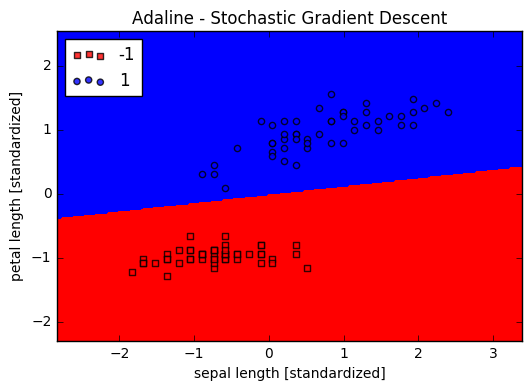

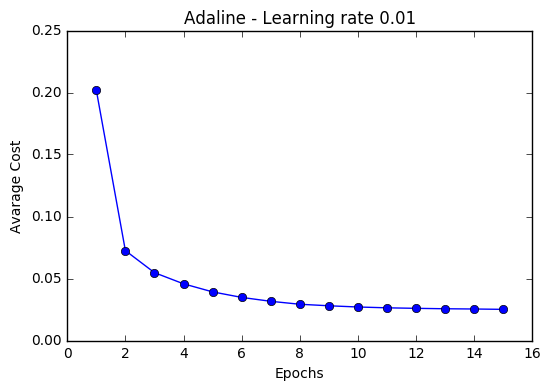

In [6]:
# 学習
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
# モデルの適合
ada.fit(X_std, y)
# 決定境界のプロット
plot_decision_regions(X_std, y, classifier=ada, xlabel='sepal length [standardized]', ylabel='petal length [standardized]', title='Adaline - Stochastic Gradient Descent')
# トレーニング回数とコストのプロット
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
# 軸のラベル設定
plt.xlabel('Epochs')
plt.ylabel('Avarage Cost')
# タイトルの設定
plt.title('Adaline - Learning rate 0.01')
# 図の表示
plt.show()